In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import torch

from escnn import gspaces
from escnn import nn

In [2]:
from e3nn import o3

import matplotlib.pyplot as plt


from neurorient import get_model_size, display_images
from neurorient.predictors import BaseSO3Predictor, I2S
from neurorient.external.image2sphere import so3_healpix_grid, flat_wigner, wigner_D, plot_so3_distribution

In [58]:
# model = I2S(
#     encoder='e2wrn',
#     encoder_input_shape=(1, 128, 128),
#     eval_wigners_file='/pscratch/sd/z/zhantao/neurorient_repo/data/eval_wigners_lmax6_rec5.pt'
#     )

# define equally spaced grid over so3
# it can be slow to generate grid for large rec_levels
# output_xyx = so3_healpix_grid(rec_level=model.train_grid_rec_level) # 37K points
# output_wigners = flat_wigner(model.lmax, *output_xyx).transpose(0, 1)
# output_rotmats = o3.angles_to_matrix(*output_xyx)

from neurorient.encoders.e2wrn import Wide_ResNet
import torchvision.models.resnet as resnet
from neurorient.predictors import ResNet2Rot6d

In [46]:
model.fc.in_features

512

In [67]:
model = ResNet2Rot6d(size=18, pretrained=True, pool_features=False)

In [68]:
model

ResNet2Rot6d(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [69]:
get_model_size(model)

model size: 42.684MB


42.68352508544922

In [49]:
# create random input for demonstration purposes
img = torch.randn((1, 3, 128, 128))
spi_data = torch.load('/pscratch/sd/z/zhantao/neurorient_repo/data/1bxr_train.pt')
img = spi_data['images'][0].unsqueeze(0).unsqueeze(0)
# img = img.repeat(1,3,1,1)

gt_rot = torch.eye(3).unsqueeze(0)


In [53]:
import torchvision
from pytorch3d.transforms import rotation_6d_to_matrix

In [50]:
images = []
for angle in [30, 45, 90, 135, 180]:
    img_rotated = torchvision.transforms.functional.rotate(img, angle)
    images.append(img_rotated)

images = torch.vstack(images)

In [51]:
img_embed = model(images.repeat(1,3,1,1)).detach().cpu()

In [55]:
rotation_6d_to_matrix(img_embed).shape

torch.Size([5, 3, 3])

In [35]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

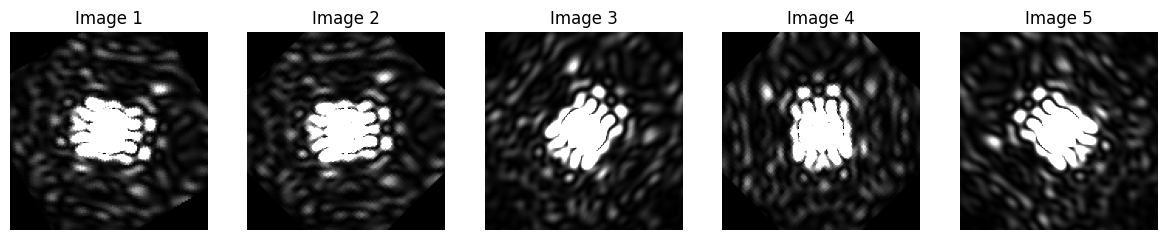

In [31]:
display_images(images[:,0], columns=8, vmax=3)

TypeError: Invalid shape () for image data

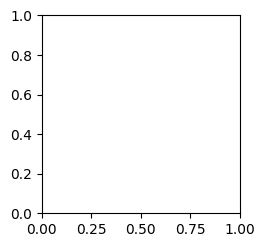

In [32]:
display_images(img_embed[:,4], columns=8)

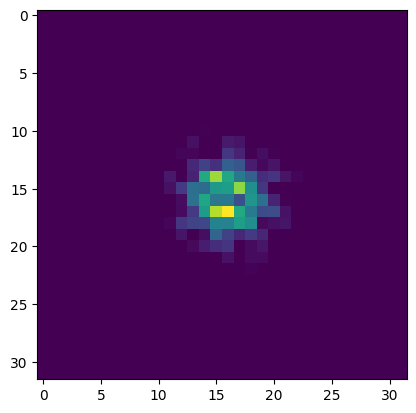

In [14]:
plt.imshow(img_embed[0,0])

In [182]:
avg_rotmats = model.compute_average_rotmats(images, model.output_wigners)

In [171]:
import torch
from pytorch3d.transforms import so3_exponential_map
from pytorch3d.transforms import random_quaternions

def random_rotation_matrix(num_samples=1):
    """Generate a random rotation matrix."""
    q = random_quaternions(num_samples)
    R = quaternion_to_matrix(q)
    return R

def batch_sample_perturbed_rotation_matrix_pt3d(R_original, num_samples, std_deviation=0.1):
    # 1. Sample num_samples small rotations in axis-angle format
    tangent_vecs = torch.normal(mean=0.0, std=std_deviation, size=(num_samples, 3))
    
    # 2. Convert axis-angle to rotation matrices
    perturbation_matrices = so3_exponential_map(tangent_vecs)
    
    # 3. Multiply the original matrix with each of the perturbation matrices
    R_perturbed = torch.matmul(R_original.unsqueeze(0).expand(num_samples, -1, -1), perturbation_matrices)
    
    return R_perturbed

# Test
R_original = random_rotation_matrix()  # Identity rotation
print(R_original)
print(matrix_to_quaternion(R_original))
num_samples = 10000
R_perturbed_batch = batch_sample_perturbed_rotation_matrix_pt3d(R_original.squeeze(), num_samples)



tensor([[[ 0.9528, -0.3026, -0.0243],
         [ 0.1594,  0.4303,  0.8885],
         [-0.2584, -0.8505,  0.4582]]])
tensor([[ 0.8428, -0.5158,  0.0694,  0.1370]])


In [172]:
matrix_to_quaternion(R_perturbed_batch).mean(dim=0)

tensor([ 0.8394, -0.5144,  0.0700,  0.1359])

In [173]:
avg_matrix = weighted_average_matrices(R_perturbed_batch, torch.ones(1,len(R_perturbed_batch)) / len(R_perturbed_batch))
print(avg_matrix)
avg_quaternion = matrix_to_quaternion(avg_matrix)
print(avg_quaternion)

tensor([[[ 0.9529, -0.3024, -0.0225],
         [ 0.1573,  0.4296,  0.8892],
         [-0.2592, -0.8509,  0.4569]]])
tensor([[ 0.8425, -0.5163,  0.0703,  0.1364]])


In [186]:
import skopi
from neurorient.utils_transform import weighted_average_matrices, weighted_average_quaternions, nice_orientation

for i in range(10):
    base_quat = skopi.get_random_quat(1)
    print(base_quat)
    quats = skopi.get_preferred_orientation_quat(sigma=1, num_pts=1000, base_quat=base_quat[0])
    avg_mat = weighted_average_matrices(quaternion_to_matrix(torch.from_numpy(quats)), torch.ones(1,len(quats)) / len(quats))
    print(matrix_to_quaternion(avg_mat).numpy())

[[ 0.47193434 -0.37924878  0.0880534  -0.79100881]]
[[-0.46112515  0.37915319 -0.08436046  0.79780309]]
[[ 0.58168633 -0.3787918  -0.03105419  0.71916161]]
[[ 0.58314694 -0.37014279 -0.02444405  0.72272848]]
[[ 0.39632691 -0.24501368  0.12109626  0.87648672]]
[[ 0.40028361 -0.23190124  0.12597366  0.87756794]]
[[ 0.18999762 -0.9191118   0.28516505 -0.19446157]]
[[-0.20020629  0.91697075 -0.28323253  0.19713299]]
[[-0.06085774 -0.11953683 -0.34315099  0.92965299]]
[[-0.05845959 -0.10920252 -0.34025075  0.93214093]]
[[-0.23513715 -0.92412018 -0.25202364  0.1649136 ]]
[[ 0.22768972  0.92496739  0.2519012  -0.17070005]]
[[ 0.39430457 -0.30079393  0.43331133 -0.75252124]]
[[-0.40989322  0.30942776 -0.42350981  0.7462449 ]]
[[-0.19701112 -0.24794605 -0.89227571 -0.3217972 ]]
[[0.18358087 0.25369922 0.89651781 0.31335377]]
[[ 0.40656677 -0.11755728  0.58555337  0.6913834 ]]
[[ 0.41321473 -0.10446455  0.5853303   0.68973124]]
[[ 0.23190772  0.84425086  0.48301566 -0.01245693]]
[[ 0.22652083  0

In [176]:
test_mats = torch.stack(test_mats)

In [177]:
test_mats.shape

torch.Size([10, 10000, 3, 3])

In [178]:
R2 = weighted_average_matrices(quaternion_to_matrix(torch.from_numpy(quats)), torch.ones(1,len(quats)) / len(quats))

In [179]:
print(matrix_to_quaternion(R2))

tensor([[ 0.1661, -0.2224,  0.9460,  0.1673]], dtype=torch.float64)


In [158]:
so3_relative_angle(R1, R2)

tensor([1.4287], dtype=torch.float64)

In [108]:
from pytorch3d.transforms import matrix_to_quaternion, quaternion_to_matrix, matrix_to_axis_angle, quaternion_to_axis_angle, so3_relative_angle

In [14]:
probs = model.compute_probabilities(img, output_wigners, use_o_for_eval=True)

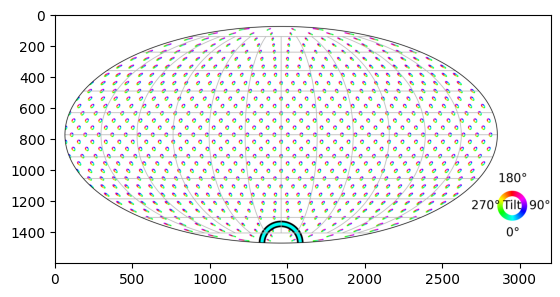

In [15]:
import matplotlib.pyplot as plt
fig = plot_so3_distribution(probs[0], output_rotmats, gt_rotation=gt_rot);
plt.imshow(fig)

In [44]:
from neurorient import weighted_average_matrices
from tqdm import tqdm 

In [45]:
for i in tqdm(range(1000)):
    weighted_average_matrices(output_rotmats.to('cuda'), probs[0].to('cuda'))

100%|██████████| 1000/1000 [00:04<00:00, 216.88it/s]
